# **Metodología Mejorada para el Análisis Exploratorio y Discretización de Engagement**

## **4. Metodología**

### **4.1 Procesamiento de datos**

El procesamiento de datos garantiza que la variable *Engagement* y el resto del conjunto estén en condiciones óptimas para su análisis.

#### **a) Limpieza**

* **Valores faltantes:**

  * Identificación de registros incompletos.
  * Aplicación de imputación o eliminación según el porcentaje y relevancia.
* **Duplicados:**

  * Detección de registros repetidos por persona, fecha o combinaciones clave.
  * Conservación únicamente de entradas válidas.
* **Outliers:**

  * Uso de métodos como IQR, Z-score o visualizaciones (boxplots).
  * Decisión informada: corregir, transformar o excluir según el caso.

#### **b) Transformaciones**

* **Normalización o estandarización** (solo si se requieren comparaciones o métodos sensibles a escala).
* **Codificación de variables categóricas** para análisis comparativo por equipo, región, etc.
* **Transformaciones matemáticas** para revisar posibles relaciones funcionales:

  * Logaritmos
  * Potencias/polinomios
  * Escalados no lineales
* **Creación de variables derivadas**:

  * Engagement por día
  * Variación diaria o semanal
  * Tasa de crecimiento o decaimiento

---

### **4.2 Análisis Exploratorio de Datos (EDA)**

El EDA se centra en **entender la estructura, distribución y comportamiento temporal del Engagement**, para así fundamentar una discretización adecuada.

#### **a) Análisis de distribución**

* **Histogramas** para visualizar forma y dispersión.
* **KDE (Kernel Density Estimation)** para detectar modos (bimodalidad, sesgos).
* **Boxplots y violín plots** para identificar rangos típicos, asimetrías y outliers.

#### **b) Análisis estadístico descriptivo**

* Medidas clave:

  * Media, mediana, moda
  * Desviación estándar
  * Cuartiles (Q1, Q2, Q3)
  * Percentiles relevantes (P10, P25, P75, P90)
* Evaluación de:

  * Sesgo
  * Curtosis
  * Estabilidad temporal

Estas métricas ayudan a definir puntos de quiebre naturales para discretización.

#### **c) Análisis temporal**

* Series de tiempo por empleado, equipo y global.
* Gráficas de líneas para detectar tendencias, ciclos o cambios bruscos.
* Cálculo de estabilidad:

  * Varianza por persona
  * Diferencias día a día (ΔEngagement)

Esto permite definir discretizaciones adaptadas a la dinámica real del comportamiento.

#### **d) Análisis por segmentos**

* Comparación de Engagement según:

  * Equipo
  * Rol
  * Seniority
  * Proyecto
  * Región/horario
* Boxplots segmentados
* Distribuciones acumuladas para ver consistencia entre grupos.

Si los segmentos presentan distribuciones distintas, la discretización podría necesitar ser **dependiente del grupo**.

#### **e) Identificación de reglas naturales para discretizar**

A partir de los análisis previos, identificar:

* **Umbrales naturales** (quiebres claros en histogramas/KDE).
* **Rangos basados en cuartiles**:

  * Bajo (< Q1),
  * Medio (Q1–Q3),
  * Alto (> Q3)
* **Clusters** si existen grupos bien definidos:

  * Aplicación opcional de K-Means o Gaussian Mixture Models
  * Validación con métodos como silhouette score.

#### **f) Evaluación de múltiples esquemas de discretización**

Para asegurar robustez:

* Probar alternativas:

  * Cuartiles
  * Terciles
  * Quintiles
  * K-means
  * Natural breaks (Jenks)
* Comparar:

  * Balance entre categorías
  * Estabilidad temporal
  * Interpretabilidad
  * Relación con KPIs o métricas relevantes

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer
from scipy import stats

In [4]:
data = pd.read_csv('data/data_globant.csv')  # Cargar los datos
data.head()

,Date,Email,Name,Position,Seniority,Location,Studio,Client,Client Tag,Project,Project Tag,Team Name,Engagement,Email Leader,Year,Month,Day
0,02Jan23,natalia.ramirez@tec.globant.com,Natalia Ramírez,Software Developer,Jr,CO/ANT/MED,Engineering,GreenWave Innovations,GWI001,Atlas Initiative,ATLINT,Breaking Badger,3.04,laura.leon@tec.globant.com,2023,1,2
1,03Jan23,natalia.ramirez@tec.globant.com,Natalia Ramírez,Software Developer,Jr,CO/ANT/MED,Engineering,GreenWave Innovations,GWI001,Atlas Initiative,ATLINT,Breaking Badger,2.99,laura.leon@tec.globant.com,2023,1,3
2,04Jan23,natalia.ramirez@tec.globant.com,Natalia Ramírez,Software Developer,Jr,CO/ANT/MED,Engineering,GreenWave Innovations,GWI001,Atlas Initiative,ATLINT,Breaking Badger,2.97,laura.leon@tec.globant.com,2023,1,4
3,05Jan23,natalia.ramirez@tec.globant.com,Natalia Ramírez,Software Developer,Jr,CO/ANT/MED,Engineering,GreenWave Innovations,GWI001,Atlas Initiative,ATLINT,Breaking Badger,2.75,laura.leon@tec.globant.com,2023,1,5
4,06Jan23,natalia.ramirez@tec.globant.com,Natalia Ramírez,Software Developer,Jr,CO/ANT/MED,Engineering,GreenWave Innovations,GWI001,Atlas Initiative,ATLINT,Breaking Badger,3.15,laura.leon@tec.globant.com,2023,1,6


In [5]:
# Limpieza de datos
print('Información del dataset:')
data.info()
print('\nValores faltantes por columna:')
print(data.isnull().sum())
print('\nNúmero de duplicados:', data.duplicated().sum())
if data.duplicated().sum() > 0:
    data = data.drop_duplicates()
    print('Duplicados eliminados.')
# Outliers en Engagement usando IQR
Q1 = data['Engagement'].quantile(0.25)
Q3 = data['Engagement'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = data[(data['Engagement'] < lower_bound) | (data['Engagement'] > upper_bound)]
print(f'\nNúmero de outliers en Engagement: {len(outliers)}')
print(f'Rango típico: [{lower_bound:.2f}, {upper_bound:.2f}]')
# Convertir Date a datetime
data['Date'] = pd.to_datetime(data['Date'], format='%d%b%y')

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11366 entries, 0 to 11365
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          11366 non-null  object 
 1   Email         11366 non-null  object 
 2   Name          11366 non-null  object 
 3   Position      11366 non-null  object 
 4   Seniority     11366 non-null  object 
 5   Location      11366 non-null  object 
 6   Studio        11366 non-null  object 
 7   Client        11366 non-null  object 
 8   Client Tag    11366 non-null  object 
 9   Project       11366 non-null  object 
 10  Project Tag   11366 non-null  object 
 11  Team Name     11366 non-null  object 
 12  Engagement    11366 non-null  float64
 13  Email Leader  10226 non-null  object 
 14  Year          11366 non-null  int64  
 15  Month         11366 non-null  int64  
 16  Day           11366 non-null  int64  
dtypes: float64(1), int64(3), object(13)
memory u

Estadísticas descriptivas de Engagement:
count    11366.000000
mean         2.995252
std          1.005442
min          0.000000
25%          2.520000
50%          3.050000
75%          3.600000
max          5.000000
Name: Engagement, dtype: float64

Percentiles:
0.10    2.00
0.25    2.52
0.50    3.05
0.75    3.60
0.90    4.14
Name: Engagement, dtype: float64

Sesgo: -0.82
Curtosis: 1.49


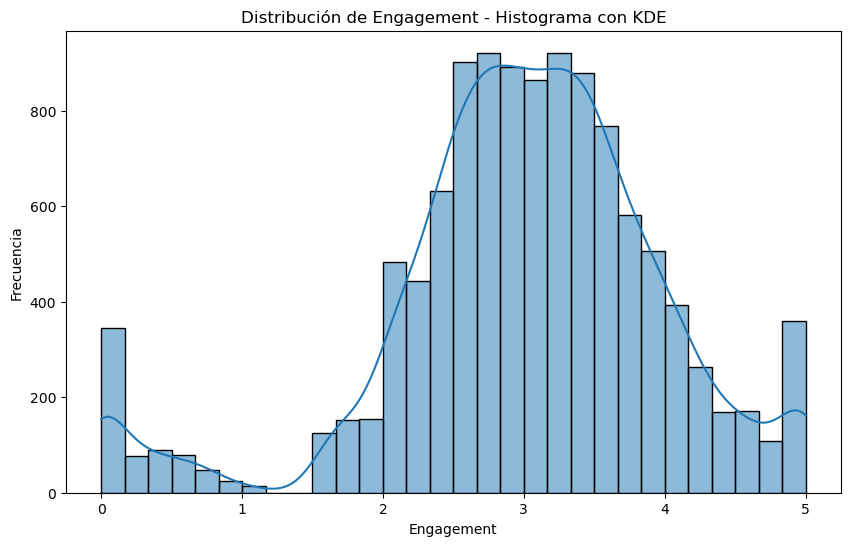

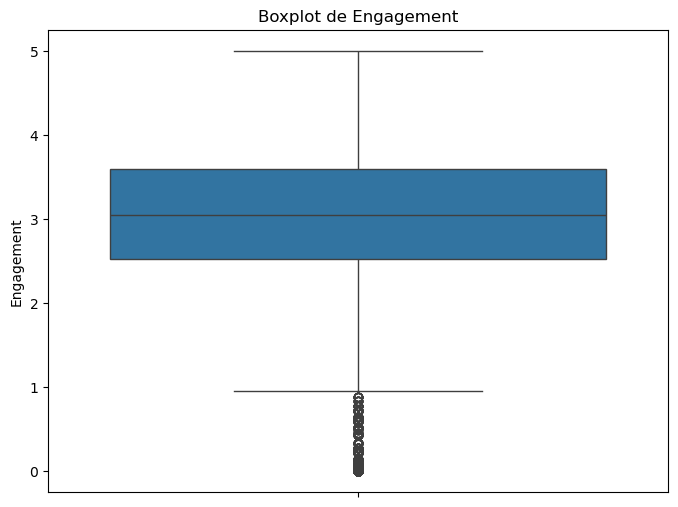

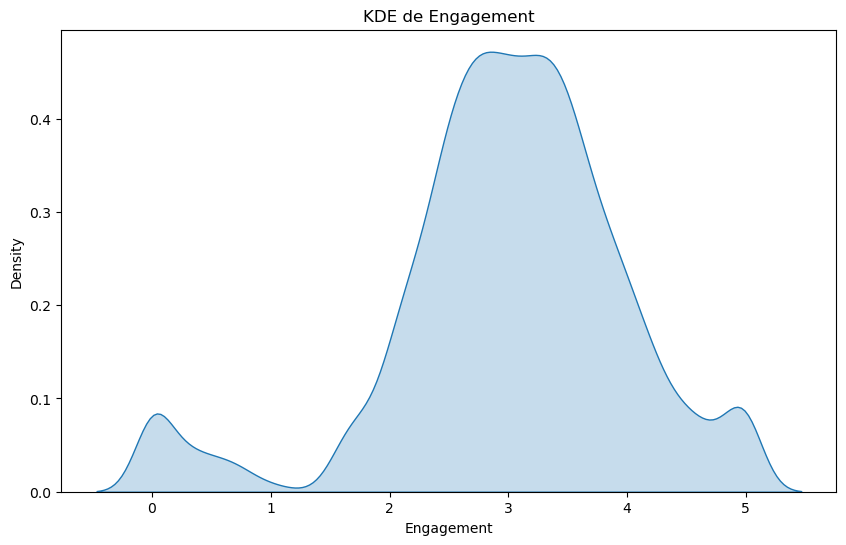

In [6]:
# Análisis Exploratorio de Datos - Distribución
print('Estadísticas descriptivas de Engagement:')
print(data['Engagement'].describe())
print('\nPercentiles:')
print(data['Engagement'].quantile([0.1, 0.25, 0.5, 0.75, 0.9]))
print(f'\nSesgo: {data["Engagement"].skew():.2f}')
print(f'Curtosis: {data["Engagement"].kurtosis():.2f}')
# Histograma con KDE
plt.figure(figsize=(10,6))
sns.histplot(data['Engagement'], kde=True, bins=30)
plt.title('Distribución de Engagement - Histograma con KDE')
plt.xlabel('Engagement')
plt.ylabel('Frecuencia')
plt.show()
# Boxplot
plt.figure(figsize=(8,6))
sns.boxplot(y=data['Engagement'])
plt.title('Boxplot de Engagement')
plt.show()
# KDE separado
plt.figure(figsize=(10,6))
sns.kdeplot(data['Engagement'], fill=True)
plt.title('KDE de Engagement')
plt.xlabel('Engagement')
plt.show()

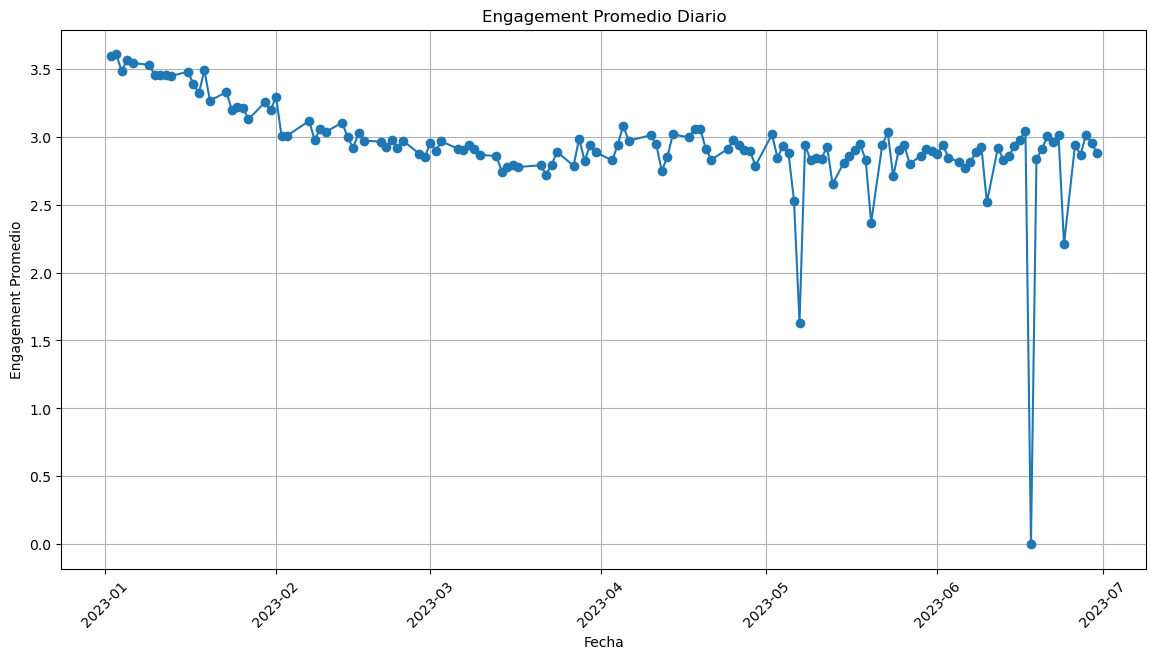

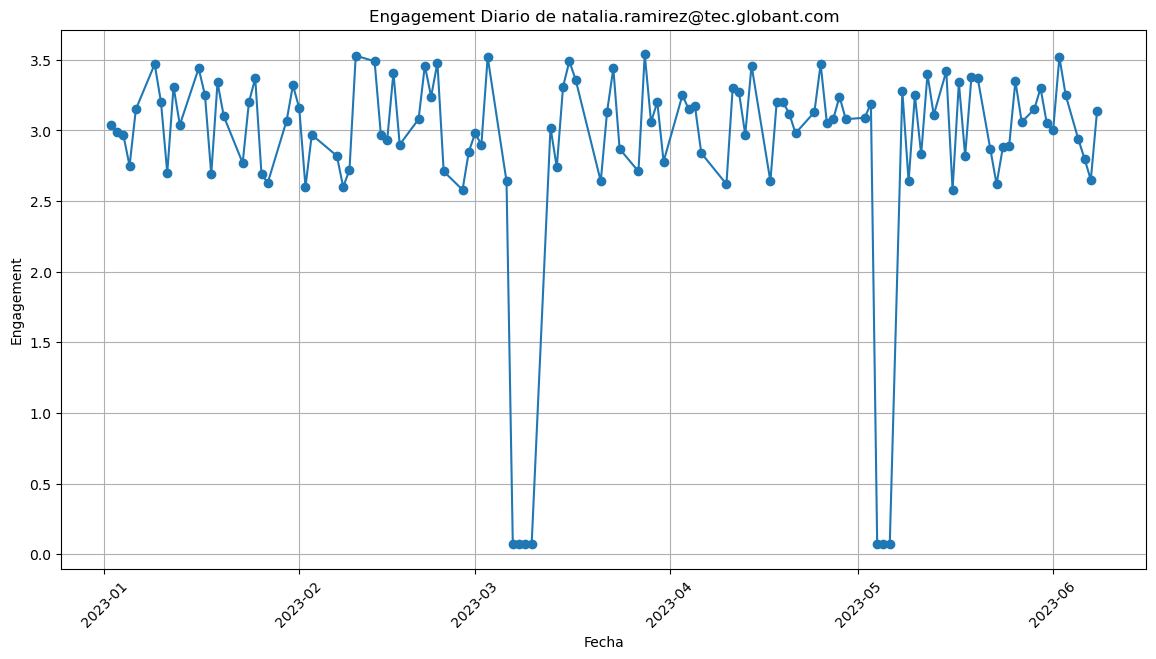

Varianza promedio de Engagement por persona: 0.7179593689594184

Estadísticas de diferencias día a día:
count    11272.000000
mean        -0.006412
std          0.866946
min         -4.900000
25%         -0.240000
50%          0.000000
75%          0.230000
max          4.900000
Name: Engagement_diff, dtype: float64


In [7]:
# Análisis Temporal
# Engagement promedio por día
daily_engagement = data.groupby('Date')['Engagement'].mean().reset_index()
plt.figure(figsize=(14,7))
plt.plot(daily_engagement['Date'], daily_engagement['Engagement'], marker='o')
plt.title('Engagement Promedio Diario')
plt.xlabel('Fecha')
plt.ylabel('Engagement Promedio')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
# Serie de tiempo para un empleado de ejemplo
employee = data['Email'].unique()[0]
emp_data = data[data['Email'] == employee].sort_values('Date')
plt.figure(figsize=(14,7))
plt.plot(emp_data['Date'], emp_data['Engagement'], marker='o')
plt.title(f'Engagement Diario de {employee}')
plt.xlabel('Fecha')
plt.ylabel('Engagement')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
# Varianza por persona
variance_per_person = data.groupby('Email')['Engagement'].var()
print('Varianza promedio de Engagement por persona:', variance_per_person.mean())
# Diferencias día a día
data_sorted = data.sort_values(['Email', 'Date'])
data_sorted['Engagement_diff'] = data_sorted.groupby('Email')['Engagement'].diff()
print('\nEstadísticas de diferencias día a día:')
print(data_sorted['Engagement_diff'].dropna().describe())

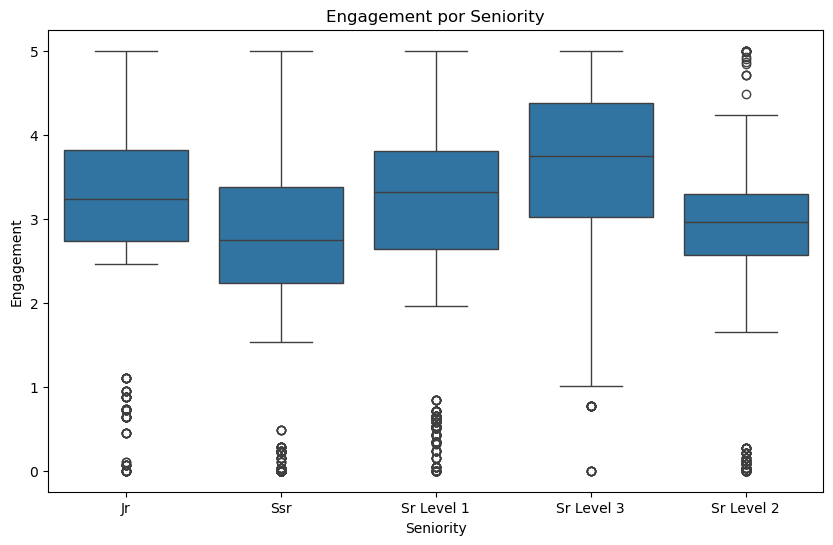

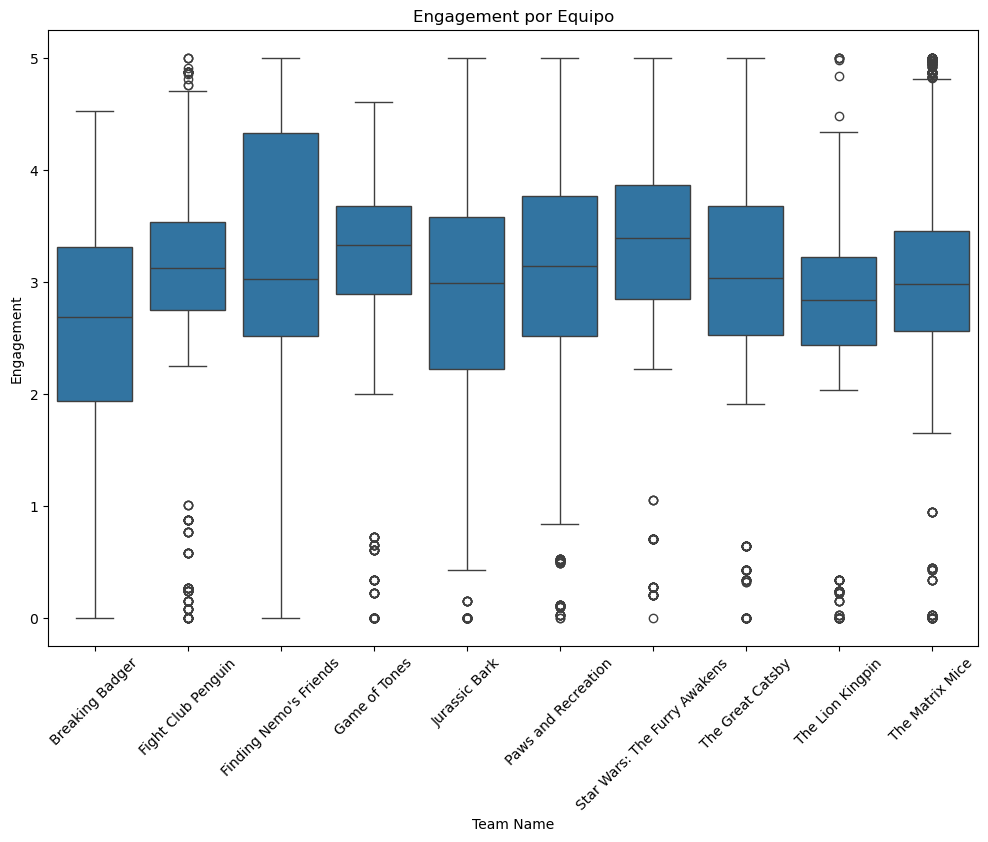

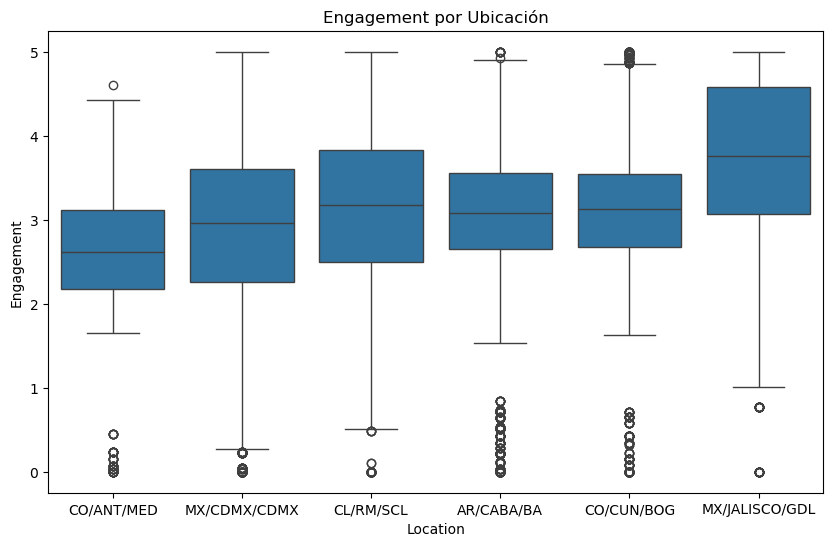

Media de Engagement por Seniority:
Seniority
Jr            3.239536
Sr Level 1    3.177163
Sr Level 2    2.825160
Sr Level 3    3.615582
Ssr           2.755869
Name: Engagement, dtype: float64

Media por Equipo:
Team Name
Breaking Badger                 2.620415
Fight Club Penguin              2.985719
Finding Nemo's Friends          3.231062
Game of Tones                   3.121522
Jurassic Bark                   2.889323
Paws and Recreation             3.099356
Star Wars: The Furry Awakens    3.356747
The Great Catsby                3.014105
The Lion Kingpin                2.754529
The Matrix Mice                 2.988195
Name: Engagement, dtype: float64

Media por Ubicación:
Location
AR/CABA/BA        3.003495
CL/RM/SCL         3.037897
CO/ANT/MED        2.639639
CO/CUN/BOG        3.056737
MX/CDMX/CDMX      2.869904
MX/JALISCO/GDL    3.691915
Name: Engagement, dtype: float64


In [8]:
# Análisis por Segmentos
# Engagement por Seniority
plt.figure(figsize=(10,6))
sns.boxplot(x='Seniority', y='Engagement', data=data)
plt.title('Engagement por Seniority')
plt.show()
# Engagement por Equipo
plt.figure(figsize=(12,8))
sns.boxplot(x='Team Name', y='Engagement', data=data)
plt.title('Engagement por Equipo')
plt.xticks(rotation=45)
plt.show()
# Engagement por Ubicación
plt.figure(figsize=(10,6))
sns.boxplot(x='Location', y='Engagement', data=data)
plt.title('Engagement por Ubicación')
plt.show()
# Estadísticas descriptivas por segmento
print('Media de Engagement por Seniority:')
print(data.groupby('Seniority')['Engagement'].mean())
print('\nMedia por Equipo:')
print(data.groupby('Team Name')['Engagement'].mean())
print('\nMedia por Ubicación:')
print(data.groupby('Location')['Engagement'].mean())

Cuartiles de Engagement:
0.25    2.52
0.50    3.05
0.75    3.60
Name: Engagement, dtype: float64

Distribución por categorías cuartiles:
Engagement_quartiles
Bajo          2934
Medio-Alto    2867
Alto          2807
Medio-Bajo    2758
Name: count, dtype: int64

Centros de clusters:
[3.86089752 2.63847488 0.26615611]

Distribución por clusters:
Engagement_clusters
1    5998
0    4689
2     679
Name: count, dtype: int64


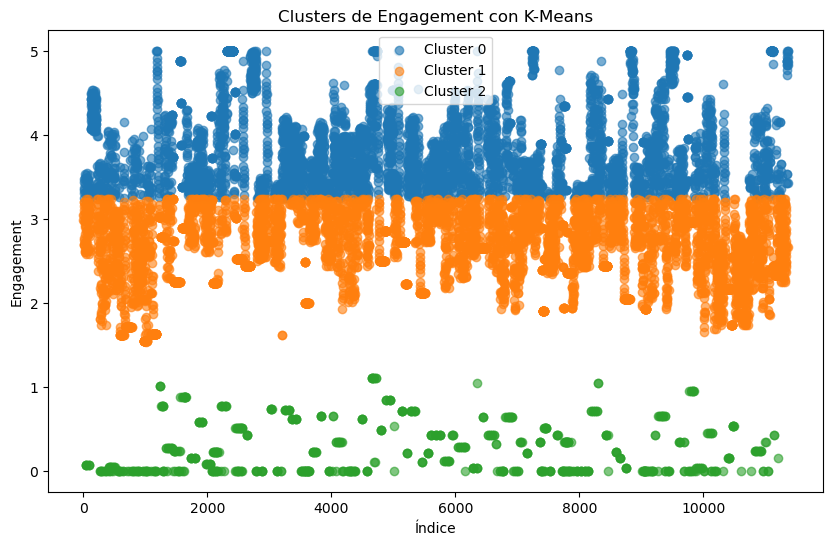

In [9]:
# Identificación de reglas naturales para discretización
# Cuartiles
quartiles = data['Engagement'].quantile([0.25, 0.5, 0.75])
print('Cuartiles de Engagement:')
print(quartiles)
# Categorías basadas en cuartiles
def categorize_quartiles(x):
    if x <= quartiles[0.25]:
        return 'Bajo'
    elif x <= quartiles[0.5]:
        return 'Medio-Bajo'
    elif x <= quartiles[0.75]:
        return 'Medio-Alto'
    else:
        return 'Alto'
data['Engagement_quartiles'] = data['Engagement'].apply(categorize_quartiles)
print('\nDistribución por categorías cuartiles:')
print(data['Engagement_quartiles'].value_counts())
# Clusters con K-Means
from sklearn.cluster import KMeans
engagement = data[['Engagement']]
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
data['Engagement_clusters'] = kmeans.fit_predict(engagement)
print('\nCentros de clusters:')
print(kmeans.cluster_centers_.flatten())
print('\nDistribución por clusters:')
print(data['Engagement_clusters'].value_counts())
# Visualizar clusters
plt.figure(figsize=(10,6))
colors = ['red', 'blue', 'green']
for cluster in sorted(data['Engagement_clusters'].unique()):
    subset = data[data['Engagement_clusters'] == cluster]
    plt.scatter(subset.index, subset['Engagement'], label=f'Cluster {cluster}', alpha=0.6)
plt.title('Clusters de Engagement con K-Means')
plt.xlabel('Índice')
plt.ylabel('Engagement')
plt.legend()
plt.show()

In [10]:
# Evaluación de múltiples esquemas de discretización
# Terciles
terciles = data['Engagement'].quantile([1/3, 2/3])
print('Terciles de Engagement:')
print(terciles)
def categorize_terciles(x):
    if x <= terciles[1/3]:
        return 'Bajo'
    elif x <= terciles[2/3]:
        return 'Medio'
    else:
        return 'Alto'
data['Engagement_terciles'] = data['Engagement'].apply(categorize_terciles)
print('\nDistribución terciles:')
print(data['Engagement_terciles'].value_counts())
# Quintiles
quintiles = data['Engagement'].quantile([0.2, 0.4, 0.6, 0.8])
print('\nQuintiles:')
print(quintiles)
# KBinsDiscretizer
kbins = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
data['Engagement_kbins'] = kbins.fit_transform(engagement)
print('\nDistribución KBins (3 bins):')
print(data['Engagement_kbins'].value_counts())
# Comparar balance entre esquemas
schemes = ['Engagement_quartiles', 'Engagement_terciles', 'Engagement_clusters', 'Engagement_kbins']
for scheme in schemes:
    print(f'\nBalance para {scheme}:')
    print(data[scheme].value_counts())
# Estabilidad temporal: cuartiles por mes
data['Month'] = data['Date'].dt.month
monthly_quartiles = data.groupby('Month')['Engagement'].quantile([0.25, 0.5, 0.75])
print('\nCuartiles por mes:')
print(monthly_quartiles)

Terciles de Engagement:
0.333333    2.72
0.666667    3.41
Name: Engagement, dtype: float64

Distribución terciles:
Engagement_terciles
Bajo     3899
Alto     3752
Medio    3715
Name: count, dtype: int64

Quintiles:
0.2    2.41
0.4    2.85
0.6    3.27
0.8    3.74
Name: Engagement, dtype: float64

Distribución KBins (3 bins):
Engagement_kbins
2.0    3825
1.0    3774
0.0    3767
Name: count, dtype: int64

Balance para Engagement_quartiles:
Engagement_quartiles
Bajo          2934
Medio-Alto    2867
Alto          2807
Medio-Bajo    2758
Name: count, dtype: int64

Balance para Engagement_terciles:
Engagement_terciles
Bajo     3899
Alto     3752
Medio    3715
Name: count, dtype: int64

Balance para Engagement_clusters:
Engagement_clusters
1    5998
0    4689
2     679
Name: count, dtype: int64

Balance para Engagement_kbins:
Engagement_kbins
2.0    3825
1.0    3774
0.0    3767
Name: count, dtype: int64

Cuartiles por mes:
Month      
1      0.25    2.9125
       0.50    3.4400
       0.75    

4. Metodología
    - Modelo(s):
        * Justificación de la elección del modelo o técnica.
        * Supuestos e hiperparámetros (si aplican).
        * Implementación del modelo.
        * Ajuste de hiperparámetros (si aplica): Random search, grid search, Bayesian optimization.
    - Evaluación:
        * Métricas utilizadas para evaluar el desempeño (precisión, recall, RMSE, etc.).
        * Métodos de validación (train-test split, cross-validation, etc.).
5. Resultados
    - Visualización de resultados:
        * Gráficos que expliquen el desempeño del modelo o el análisis realizado.
    - Interpretación:
        * Explicación clara de lo que significan los resultados.

6. Discusión
    - Implicaciones: Relevancia de los resultados en el contexto del problema.
    - Limitaciones: Factores que pudieron haber afectado el análisis o los resultados.
    - Posibles mejoras: Sugerencias para mejorar el análisis o los datos.

In [ ]:
# Promedio por día para tener solo una observación diaria por Team Name
# Asegúrate de que Engagement_quartiles esté en forma numérica para calcular el promedio
cuartiles_map = {'Bajo': 0, 'Medio-Bajo': 1, 'Medio-Alto': 2, 'Alto': 3}
data['Engagement_quartiles_num'] = data['Engagement_quartiles'].map(cuartiles_map)

# Agrupar por Team y Fecha → obtener el promedio diario
daily_data = (
    data.groupby(['Team Name', 'Date'], as_index=False)
        .agg({'Engagement_quartiles_num': 'mean'})
)

# Redondear el promedio al cuartil más cercano
daily_data['Engagement_quartiles_num'] = daily_data['Engagement_quartiles_num'].round().astype(int)

# Ordenar por Team y fecha
daily_data = daily_data.sort_values(['Team Name', 'Date'])
daily_data.head()

,Team Name,Date,Engagement_quartiles_num
0,Breaking Badger,2023-01-02,2
1,Breaking Badger,2023-01-03,2
2,Breaking Badger,2023-01-04,2
3,Breaking Badger,2023-01-05,2
4,Breaking Badger,2023-01-06,2


In [42]:
# Construcción de la Cadena de Markov diaria
transitions = {}

for team, group in daily_data.groupby('Team Name'):
    states = group['Engagement_quartiles_num'].values

    # Construir transiciones secuenciales entre días
    for (s1, s2) in zip(states[:-1], states[1:]):
        if s1 not in transitions:
            transitions[s1] = {}
        if s2 not in transitions[s1]:
            transitions[s1][s2] = 0
        transitions[s1][s2] += 1

# Normalizar a probabilidades (matriz de transición)
markov_matrix = pd.DataFrame(index=range(4), columns=range(4)).fillna(0)

for s1, dests in transitions.items():
    total = sum(dests.values())
    for s2, count in dests.items():
        markov_matrix.loc[s1, s2] = count / total

print('Matriz de Transición de Markov (promedio diario por Team Name):')
print(markov_matrix)


Matriz de Transición de Markov (promedio diario por Team Name):
          0         1         2         3
0  0.000000  0.750000  0.250000  0.000000
1  0.004451  0.816024  0.179525  0.000000
2  0.001789  0.227191  0.749553  0.021467
3  0.000000  0.000000  0.583333  0.416667


/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_72689/2701596389.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  markov_matrix = pd.DataFrame(index=range(4), columns=range(4)).fillna(0)
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_72689/2701596389.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7495527728085868' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  markov_matrix.loc[s1, s2] = count / total
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_72689/2701596389.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2